# Decoding stationary patterns from Mi4

This notebook will simulate Mi4 as a linear neurons with a temporally low-pass, spatially high-pass receptive field.  
Then, we try different decoding algorithm downstream of the model Mi4 to distinguish stationary patterns from uniform stimuli as well as flickering stimuli.


In [1]:
# Import packages
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt

# Also import utility functions in the repo
import utility as ut

In [34]:
# Define parameters

# Simulation itself
dx_stim = 1 # dx of the stimulus (degrees)
dx_resp = 5 # dx of neurons (degrees)
dt = 0.01 # dt of stimulus/neurons (seconds)
x_extent = 360 # degrees
t_extent = 8 # seconds
on_off_t = (1,6) # onset/offset of stimulus (seconds)

# Stimulus related
resolution = 5 # checker resolution (degrees)
param_set = ((0,0), (0,1), (15,1)) # update rate (Hz) and contrast (A.U.)

# Neuron parameters
pr_fwhm = 5.7 # photoreceptor receptive angle (degrees) (from Stavenga 2003)
mi4_tau = 0.300 # from Arenz et al. (2017) (seconds)
mi4_sigmas = (4.0,8.0) # width of pos/neg lobes. from Arenz et al. (2017) (degrees)
mi4_weights = (1,0.8) # weights of pos/neg lobes. from Arenz et al. (2017) (A.U.)

# visualization parameters
cond_names = ['uniform','stationary','flicker']
base_color = [(0.5, 0.5, 0.5),
              (0.1, 0.7, 1.0),
              (1.0, 0.1, 0.7)]
base_color = np.asarray(base_color)

## Generate stimuli
Generate the stimuli identical to what was used in the imaging experiment.  
There are three conditions: Uniform gray, stationary checkerboard (5 degree resolution), and
flickering checkerboard (5 degree resolution, 15 Hz update).  
The stimuli last for 5 seconds, with 1 s pre stimulus and 2 s post stimulus periods.

In [3]:
# Create stimuli
stim = []
for param in param_set:
    stim.append(ut.create_checker(update_rate=param[0], contrast=param[1], dx=dx_stim, dt=dt, resolution=resolution,
                                  x_extent=x_extent, t_extent=t_extent, on_off_t=on_off_t))

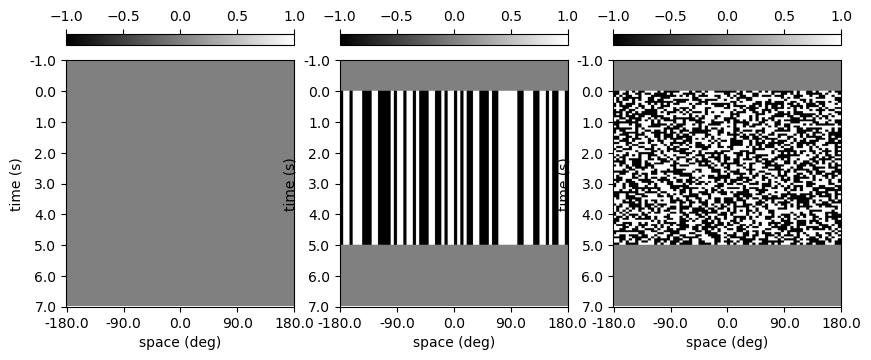

In [42]:
# Visualize to make sure they are as intended
fig = plt.figure(figsize=[10,4])
for i in range(3):
    ax = fig.add_subplot(1,3,i+1)
    im = ax.imshow(stim[i], aspect='auto', cmap='gray', vmin=-1, vmax=1)
    ut.set_image_axis(ax, im, dx_stim, x_extent, dt, t_extent, on_off_t[0])
plt.show()

## Model photoreceptor responses
Fly photoreceptors have receptive angle of ~5.7º and spacing of 5º.  
Spatial Gaussian filter of 5.7º fwhm will be convolved with the stimuli, and the output will be downsampled to 5º spacing.

In [5]:
# Calculate photoreceptor responses
pr_resp = []
for this_stim in stim:
    pr_resp.append(ut.photoreceptor_response(this_stim, dx_stim, sample_dx=dx_resp, fwhm=pr_fwhm))

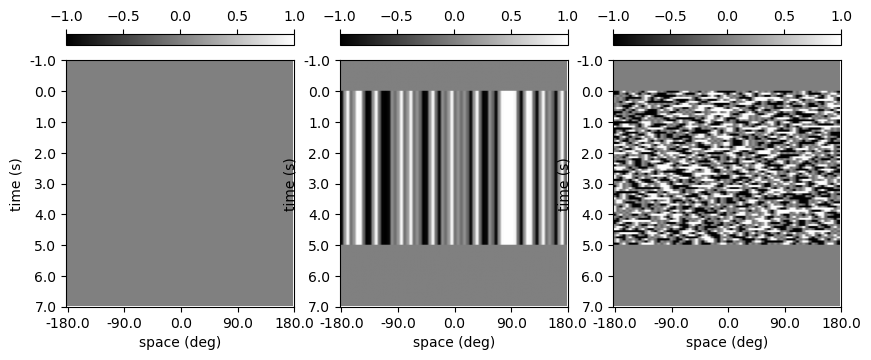

In [41]:
# Visualize photoreceptor response
fig = plt.figure(figsize=[10,4])
for i in range(3):
    ax = fig.add_subplot(1,3,i+1)
    im = ax.imshow(pr_resp[i], aspect='auto', cmap='gray', vmin=-1, vmax=1)
    ut.set_image_axis(ax, im, dx_resp, x_extent, dt, t_extent, on_off_t[0])
plt.show()

## Model Mi4 responses
Receptive field of Mi4 will be modeled as a combination of temporal low-pass filter of the shape 
$$ f(t) = kte^{-t /\tau} $$
and a difference of Gaussian spatial filter.  
Temporal and spatial filters are respectively normalized to have unit L1 and L2 norms.
The filters and the results of the convolution will be visualized.  
Also, similar across-roi averaging analysis as the Mi4 imaging experiment will be performed.

In [7]:
# Calculate Mi4 response
mi4_resp = []
for i in range(3):
    out, tf, xf = ut.mi4_response(pr_resp[i], dx_resp, dt, sigmas=mi4_sigmas, weights=mi4_weights, tau=mi4_tau)
    mi4_resp.append(out)

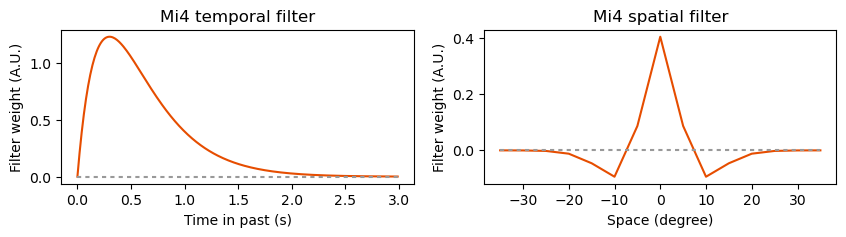

Temporal filter L1 norm 1.0000000000000002
Spatial filter L2 norm 0.9999999999999999


In [8]:
# Visualize filters to make sure they look like what has been reported
# Comapre these with Arenz et al. (2017) Curr. Biol. Fig. 2
fig = plt.figure(figsize=[10,2])

# Temporal filter
# Positive low pass filter decay back to zero after 1.5 s
ax = fig.add_subplot(1,2,1)
ax.plot(tf[1],tf[0],color=(0.9,0.3,0))
ax.plot(tf[1],tf[0]*0,color=(0.6,0.6,0.6),dashes=(2,2,2)) # dashed base-line
ax.set_xlabel('Time in past (s)')
ax.set_ylabel('Filter weight (A.U.)')
ax.set_title('Mi4 temporal filter')


# spatial filter
# "Mexican hat" with zero crossing at about 7 deg, which decays back to 0 at 20 deg
ax = fig.add_subplot(1,2,2)
ax.plot(xf[1],xf[0].T,color=(0.9,0.3,0))
ax.plot(xf[1],xf[0].T*0,color=(0.6,0.6,0.6),dashes=(2,2,2)) # dashed base-line
ax.set_xlabel('Space (degree)')
ax.set_ylabel('Filter weight (A.U.)')
ax.set_title('Mi4 spatial filter')

plt.show()

# also make sure that the normalization is working
print('Temporal filter L1 norm',np.sum(tf[0])*dt)
print('Spatial filter L2 norm',np.sqrt(np.sum(xf[0]**2)*dx_resp))

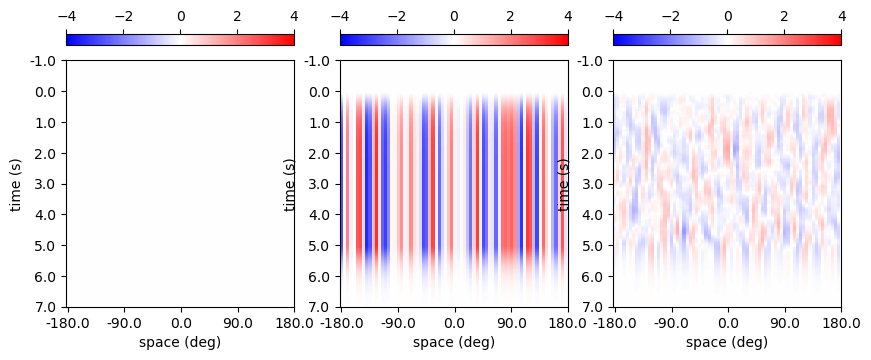

In [56]:
# Visualize Mi4 responses
fig = plt.figure(figsize=[10,4])
for i in range(3):
    ax = fig.add_subplot(1,3,i+1)
    im = ax.imshow(mi4_resp[i], aspect='auto', cmap='bwr', vmin=-4, vmax=4, interpolation='nearest')
    ut.set_image_axis(ax, im, dx_resp, x_extent, dt, t_extent, on_off_t[0])
plt.show()

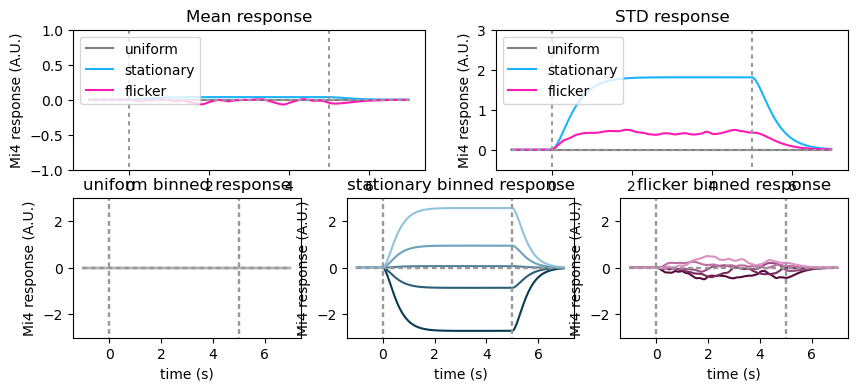

In [58]:
# Averages, standard deviation, and sorted averages, as in Fig. 6C
# prepare variables and parameters
t_vec = np.arange(mi4_resp[0].shape[0]) * dt
is_stim = np.logical_and(t_vec >= on_off_t[0], t_vec < on_off_t[1])
n_x_sample = mi4_resp[0].shape[1]
n_bins = 5
bin_edges = np.linspace(0,n_x_sample,n_bins+1,endpoint=True,dtype=int)

# preapare figure
fig = plt.figure(figsize=[10,4])

# mini utility function for baseline visualization
def plot_baseline(ax):
    ax.plot([0,0],[-10,10],c=(0.6,0.6,0.6),dashes=(2,2,2))
    ax.plot([5,5],[-10,10],c=(0.6,0.6,0.6),dashes=(2,2,2))
    ax.plot([-on_off_t[0],t_extent-on_off_t[0]],[0,0],c=(0.6,0.6,0.6),dashes=(2,2,2))

# Mean visualization
ax = fig.add_subplot(2,2,1)
for i in range(3):
    mean_resp = np.mean(mi4_resp[i],axis=1)
    ax.plot(t_vec-on_off_t[0], mean_resp, c=base_color[i], label=cond_names[i])
plot_baseline(ax)
ax.set_ylim(-1,1)
ax.set_xlabel('time (s)')
ax.set_ylabel('Mi4 response (A.U.)')
ax.set_title('Mean response')
ax.legend()

# STD visualization
ax = fig.add_subplot(2,2,2)
for i in range(3):
    mean_resp = np.std(mi4_resp[i],axis=1)
    ax.plot(t_vec-on_off_t[0], mean_resp, c=base_color[i], label=cond_names[i])
plot_baseline(ax)
ax.set_ylim(-0.5,3)
ax.set_xlabel('time (s)')
ax.set_ylabel('Mi4 response (A.U.)')
ax.set_title('STD response')
ax.legend()

# Sorted average visualization
for i in range(3):
    ax = fig.add_subplot(2,3,i+4)
    # sort and average within each bin
    integ_resp = np.mean(mi4_resp[i][is_stim,:],axis=0)
    sorted_resp = mi4_resp[i][:,np.argsort(integ_resp)]
    binned_resp = []
    for j in range(5):
        ax.plot(t_vec-on_off_t[0], np.mean(sorted_resp[:,bin_edges[j]:bin_edges[j+1]],axis=1),
               color=base_color[i,:]/3+j/5/3*2)
        plot_baseline(ax)
        ax.set_ylim(-3,3)
        ax.set_xlabel('time (s)')
        ax.set_ylabel('Mi4 response (A.U.)')
        ax.set_title(cond_names[i]+' binned response')
plt.show()

## Decoding
Try different algorithms to decode stimulus identity.

In [99]:
# Because outputs of Mi4 is linear, we cannot simply spatially average. 
# Instead, there needs to be additional retinotopically resolved units with nonlinearity
# Mi4 is a GABAergic cell, so the effect of Mi4 output needs to be always inhibitory.
# By having a simpl

# half-wave rectification function
def rectify(X):
    return X * (X>0).astype('float')

downstream_resp = []
for i in range(3):
    gaba_input = -rectify(4 + mi4_resp[i])
    downstream_resp.append(rectify(4 + gaba_input))

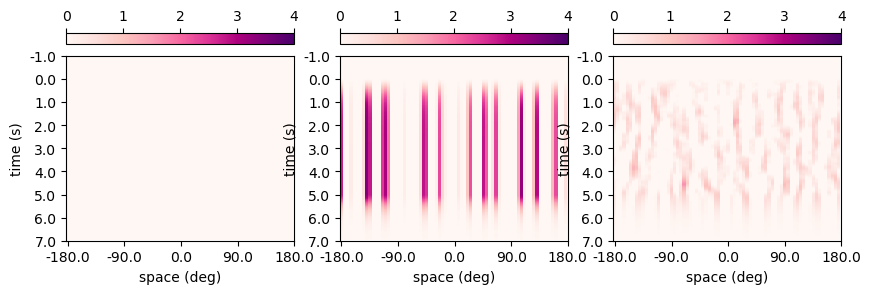

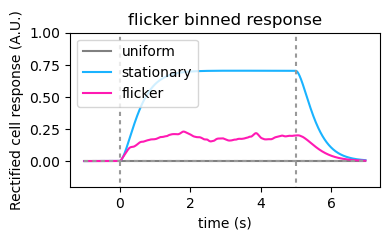

In [110]:
# Visualization
fig = plt.figure(figsize=[10,3])
for i in range(3):
    ax = fig.add_subplot(1,3,i+1)
    im = ax.imshow(downstream_resp[i], aspect='auto', cmap='RdPu', vmin=0, vmax=4, interpolation='nearest')
    ut.set_image_axis(ax, im, dx_resp, x_extent, dt, t_extent, on_off_t[0])
plt.show()

# also spatially averaged 
fig = plt.figure(figsize=[4,2])
ax = fig.add_subplot()
for i in range(3):
    ax.plot(t_vec-on_off_t[0], np.mean(downstream_resp[i],axis=1), c=base_color[i], label=cond_names[i])

plot_baseline(ax)
ax.set_ylim(-0.2,1.0)
ax.set_xlabel('time (s)')
ax.set_ylabel('Rectified cell response (A.U.)')
ax.set_title(cond_names[i]+' binned response')
ax.legend()
plt.show()